# Setup/Imports

In [1]:
import keras
import tensorflow as tf
from keras import backend as K
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import sys
import os
sys.path.append(os.path.abspath('../'))
from helpers.data_generator import process_data, DataGenerator
from helpers.custom_losses import denorm_loss, hinge_mse_loss
from helpers.normalization import normalize, denormalize, renormalize

num_cores = 4
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
                        inter_op_parallelism_threads=num_cores, 
                        allow_soft_placement=True,
                        device_count = {'CPU' : 1,
                                        'GPU' : 0})
session = tf.Session(config=config)
K.set_session(session)

Using TensorFlow backend.


In [2]:
%matplotlib inline
font={'family': 'Times New Roman',
      'size': 10}
plt.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)

avail_profiles = ['dens', 'ffprime', 'idens', 'itemp', 'press', 'rotation',
                  'temp', 'thomson_dens', 'thomson_temp']
avail_actuators = ['curr', 'ech', 'gasA', 'gasB', 'gasC', 'gasD' 'gasE', 'pinj',
                   'pinj_15L', 'pinj_15R', 'pinj_21L', 'pinj_21R', 'pinj_30L',
                   'pinj_30R', 'pinj_33L', 'pinj_33R', 'tinj']

# Functions

In [8]:
def hinge_loss(delta_true, delta_pred):
    """Finds the percentage of the time the prediction has the right sign
    """
    return np.sum(np.maximum(np.sign(delta_true*delta_pred),0))/delta_true.size

def batch_hinge(model,generator,param_dict,sig):
    """Finds the percentage of the time the prediction has the right sign
    """    
    nbatches = len(generator)
    err = 0
    for ind in range(nbatches):
        inputs, targets = generator[ind]
        predictions = model.predict_on_batch(inputs)
        full_pred, full_true, delta_pred, delta_true, baseline = batch_denorm(inputs,targets,predictions,param_dict,sig)
        err += hinge_loss(delta_true,delta_pred)
    return err/nbatches    

def batch_denorm(inputs,targets,predictions,param_dict,sig):
    """Denormalizes and calculates deltas, prep for plotting and analysis
    """
    targets = targets['target_' + sig]
    baseline = inputs['input_' + sig][:,-1]
    if predict_deltas:
        full_pred = predictions + baseline
        full_true = targets + baseline
    else:
        full_pred = predictions
        full_true = targets
    denorm_baseline = denormalize(baseline, param_dict[sig])
    denorm_full_pred = denormalize(full_pred, param_dict[sig])
    denorm_full_true = denormalize(full_true, param_dict[sig])
    denorm_delta_pred = denorm_full_pred - denorm_baseline
    denorm_delta_true = denorm_full_true - denorm_baseline
    return denorm_full_pred, denorm_full_true, denorm_delta_pred, denorm_delta_true, denorm_baseline

def plot_batch(y_true, y_pred, baseline, psi, labels, axlabels):
    batch_size = y_true.shape[0]
    ncols = 4
    nrows = int(batch_size/ncols)
    figsize = (20,10*batch_size/20)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    ax = ax.flatten()
    # Plot predictions and true deltas
    for i in range(batch_size):
        ax[i].plot(psi,y_true[i], label=labels[0])
        ax[i].plot(psi,y_pred[i], label=labels[1])
        ax[i].plot(psi,baseline[i], label=labels[2])
        ax[i].set_xlabel(axlabels[0])
        ax[i].set_ylabel(axlabels[1])
        ax[i].legend(loc=0)
    plt.tight_layout()
    return fig,ax

# Analysis

In [4]:
model_path = '/home/fouriest/SCHOOL/Princeton/PPPL/model.h5'
model = keras.models.load_model(model_path, compile=False)

Instructions for updating:
Colocations handled automatically by placer.


In [52]:
model.outputs[0].name.split('_')[1]
bool(0)

False

In [5]:
input_profile_names = ['temp', 'dens', 'rotation']
target_profile_names = ['temp']
actuator_names = ['pinj', 'curr']
predict_deltas = True
lookback = 8
lookahead = 3
profile_length = 65
rawdata_path = '/home/fouriest/SCHOOL/Princeton/PPPL/final_data.pkl'
checkpt_filepath = '/home/fouriest/SCHOOL/Princeton/PPPL/model.h5'
sig_names = input_profile_names + target_profile_names + actuator_names
normalization_method = 'StandardScaler'
window_length = 1
window_overlap = 0
sample_step = 5
uniform_normalization = True
train_frac = 0.8
val_frac = 0.2
nshots = 1000

traindata, valdata, param_dict = process_data(rawdata_path, sig_names, normalization_method,
                                              window_length, window_overlap, lookback,
                                              lookahead, sample_step, uniform_normalization,
                                              train_frac, val_frac, nshots,verbose=0)

Loading
Signals: curr, dens, pinj, rotation, temp, time


Gathering:   3%|3         | 31/1000 [00:00<00:03, 304.05it/s]

Number of useable shots:  8702
Number of shots used:  1000
Total number of timesteps:  81581


Splitting: 100%|##########| 6/6 [00:00<00:00, 170.32it/s]

Total number of samples:  14499
Number of training samples:  11599
Number of validation samples:  2900


In [6]:
batch_size = 20
train_generator = DataGenerator(traindata, batch_size, input_profile_names,
                                actuator_names, target_profile_names, lookback,
                                lookback, lookahead, predict_deltas)
val_generator = DataGenerator(valdata, batch_size, input_profile_names,
                              actuator_names, target_profile_names, lookback,
                              lookback, lookahead, predict_deltas)

In [11]:
batch_ind = 5
sig = 'temp'
inputs, targets = train_generator[batch_ind]
predictions = model.predict_on_batch(inputs)

psi = np.linspace(0,1,profile_length)
full_pred, full_true, delta_pred, delta_true, baseline = batch_denorm(inputs,targets,predictions,param_dict,sig)

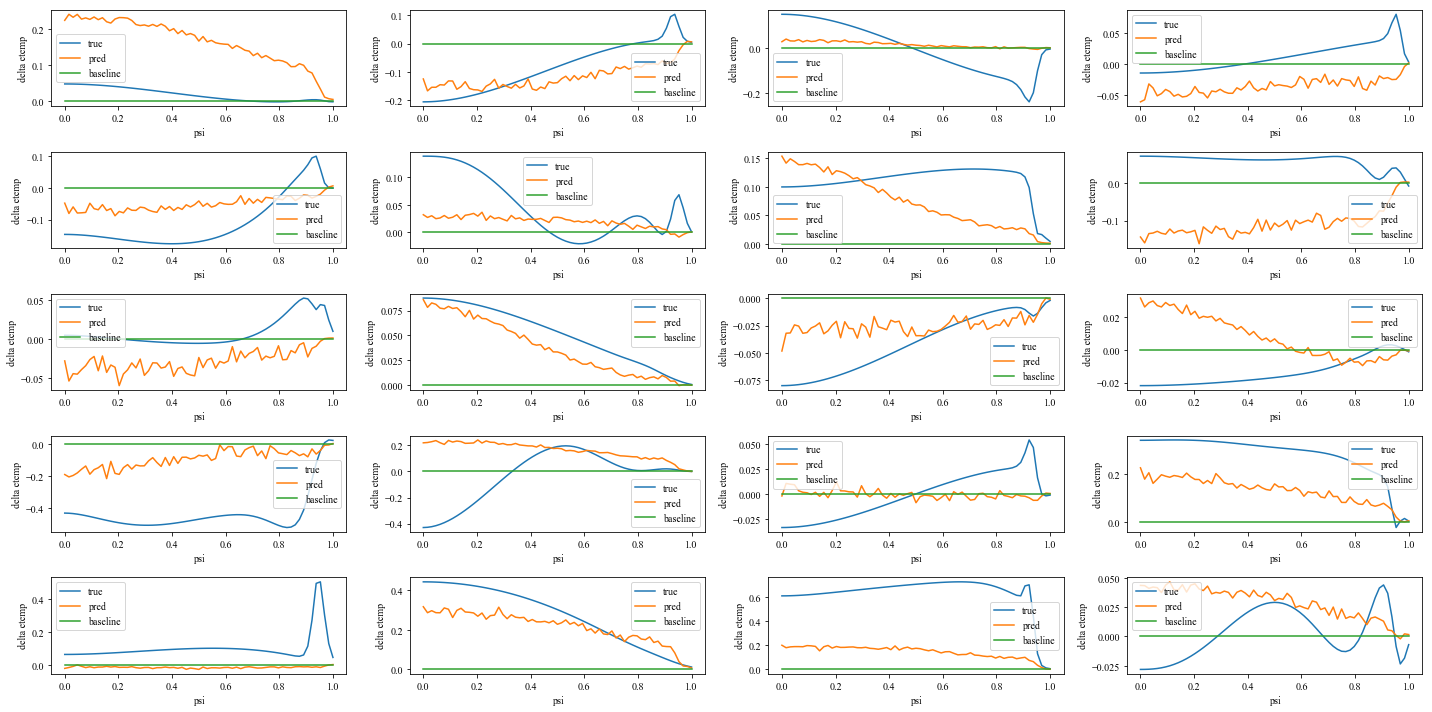

In [12]:
fig, ax = plot_batch(delta_true,delta_pred,np.zeros_like(baseline),psi,['true','pred','baseline'],['psi','delta etemp'])  

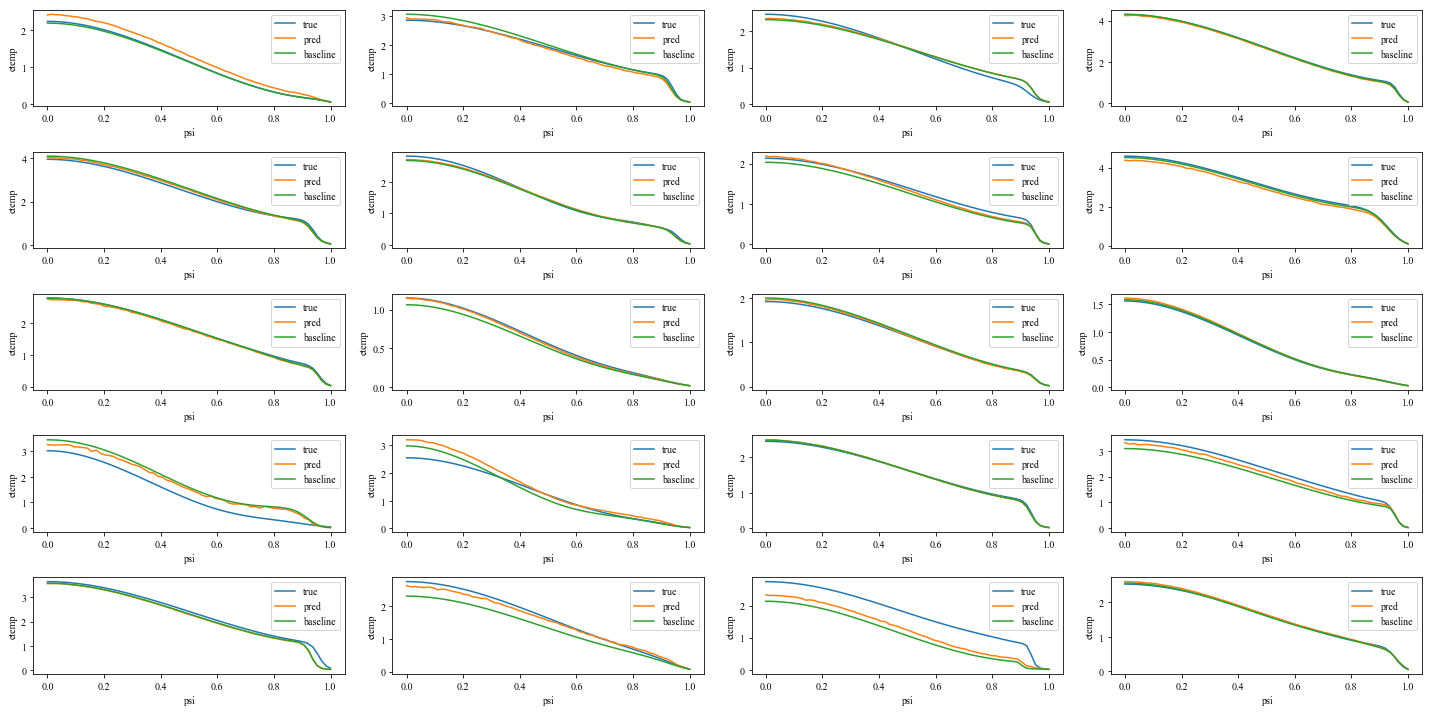

In [13]:
fig, ax = plot_batch(full_true,full_pred,baseline,psi,['true','pred','baseline'],['psi','etemp'])  

In [9]:
batch_hinge(model,train_generator,param_dict,'temp')

0.5998489459723583

In [1]:
from keras.layers import Input, Dense, LSTM, Conv1D, Conv2D, ConvLSTM2D, Dot, Add, Multiply, Concatenate, Reshape, Permute, ZeroPadding1D, Cropping1D
from keras.models import Model
import numpy as np


def get_model_LSTMConv2D(input_profile_names, target_profile_names,
                         actuator_names, lookback, lookahead, profile_length,
                         final_profile_channels):

    profile_inshape = (lookback, profile_length)
    actuator_inshape = (lookback + lookahead,)
    num_profiles = len(input_profile_names)
    num_targets = len(target_profile_names)
    num_actuators = len(actuator_names)

    profile_inputs = []
    profiles = []
    for i in range(num_profiles):
        profile_inputs.append(
            Input(profile_inshape, name='input_' + input_profile_names[i]))
        profiles.append(Reshape((lookback, profile_length, 1))
                        (profile_inputs[i]))
        profiles[i] = Dense(units=5, activation='relu')(profiles[i])
        profiles[i] = Conv2D(filters=5, kernel_size=(1, 3), strides=(1, 1), padding='same',
                             activation='relu')(profiles[i])
        profiles[i] = Dense(units=7, activation='relu')(profiles[i])
        profiles[i] = Conv2D(filters=10, kernel_size=(1, 5), strides=(1, 1), padding='same',
                             activation='relu')(profiles[i])
        profiles[i] = Dense(units=15, activation='relu')(profiles[i])
        profiles[i] = Conv2D(filters=20, kernel_size=(1, 7), strides=(1, 1), padding='same',
                             activation='relu')(profiles[i])
        profiles[i] = Reshape((lookback, profile_length, 1, 20))(profiles[i])
        profiles[i] = ConvLSTM2D(filters=final_profile_channels, kernel_size=(1, 5),
                                 strides=(1, 1), padding='same', activation='relu',
                                 recurrent_activation='hard_sigmoid',
                                 return_sequences=True)(profiles[i])
        profiles[i] = Reshape(
            (lookback, profile_length, final_profile_channels))(profiles[i])
        # shape = (5, 32, 10)

    merged = [[] for i in range(num_profiles)]
    for i in range(num_profiles):
        for j in range(num_profiles):
            merged[i].append(Dense(units=10, activation='relu')(profiles[i]))
        merged[i] = Add()(merged[i])
        # shape = (5, 32, 10)
    actuator_inputs = []
    actuators = []
    for i in range(num_actuators):
        actuator_inputs.append(
            Input(actuator_inshape, name='input_' + actuator_names[i]))
        actuators.append(Reshape((lookback+lookahead, 1))(actuator_inputs[i]))
        actuators[i] = Dense(units=5, activation='relu')(actuators[i])
        actuators[i] = Conv1D(filters=7, kernel_size=3, strides=1, padding='causal',
                              activation='relu')(actuators[i])
        actuators[i] = LSTM(units=10, activation='relu', recurrent_activation='hard_sigmoid',
                            return_sequences=True)(actuators[i])
        actuators[i] = Reshape((1, lookback+lookahead, 10))(actuators[i])
        # shape = (1, 8, channels)

    actuators = Concatenate(axis=1)(actuators)
    # shape = (num_actuators, lookback+lookahead, 10)
    prof_act = []
    for i in range(num_profiles):
        prof_act.append(Dense(units=final_profile_channels,
                              activation='relu')(actuators))
        prof_act[i] = Conv2D(filters=final_profile_channels,
                             kernel_size=(num_actuators, lookahead+1), strides=(1, 1),
                             padding='valid', activation='relu')(prof_act[i])
        # shape = (1,5,10)
        prof_act[i] = Reshape(
            (lookback, final_profile_channels, 1))(prof_act[i])
        # shape = (5,10,1)
        prof_act[i] = Dense(units=profile_length,
                            activation='relu')(prof_act[i])
        # shape = (5,10,32)
        prof_act[i] = Permute((1, 3, 2))(prof_act[i])
        # shape = (5,32,10)
        prof_act[i] = Dense(units=final_profile_channels,
                            activation='relu')(prof_act[i])

    for i in range(num_profiles):
        profiles[i] = Multiply()([profiles[i], prof_act[i]])
        profiles[i] = Add()([profiles[i], merged[i]])
        # shape = (5,32,10)
        profiles[i] = Dense(units=15, activation='relu')(profiles[i])
        profiles[i] = Conv2D(filters=20, kernel_size=(1, 5), strides=(1, 1), padding='same',
                             activation='relu')(profiles[i])
        profiles[i] = Reshape((lookback, profile_length, 1, 20))(profiles[i])
        # shape = (5,32,1 20)
        profiles[i] = ConvLSTM2D(filters=1, kernel_size=(1, 5),
                                 strides=(1, 1), padding='same', activation='relu',
                                 recurrent_activation='hard_sigmoid')(profiles[i])
        #shape = (32,1,1)
        profiles[i] = Reshape((profile_length,))(profiles[i])
        #shape = (32,)
        profiles[i] = Dense(units=profile_length, activation=None,
                            name='target_' + input_profile_names[i])(profiles[i])

    outputs = [profiles[i] for i, sig in enumerate(
        input_profile_names) if sig in target_profile_names]

    model = Model(inputs=profile_inputs + actuator_inputs, outputs=outputs)
    return model


Using TensorFlow backend.


In [10]:
input_profile_names = ['temp', 'dens', 'rotation']
target_profile_names = ['temp']
actuator_names = ['pinj', 'curr']
predict_deltas = True
profile_lookback = 8
actuator_lookback = 8
lookahead = 3
profile_length = 65
final_profile_channels = 10
rawdata_path = '/home/fouriest/SCHOOL/Princeton/PPPL/final_data.pkl'
checkpt_dir = '/home/fouriest/SCHOOL/Princeton/PPPL/'
sig_names = input_profile_names + target_profile_names + actuator_names
model = get_model_LSTMConv2D(input_profile_names, target_profile_names,
                             actuator_names, profile_lookback, lookahead, profile_length,
                             final_profile_channels)
model.compile('sgd','mse')

In [14]:
model.inputs

[<tf.Tensor 'input_temp_1:0' shape=(?, 8, 65) dtype=float32>,
 <tf.Tensor 'input_dens_1:0' shape=(?, 8, 65) dtype=float32>,
 <tf.Tensor 'input_rotation_1:0' shape=(?, 8, 65) dtype=float32>,
 <tf.Tensor 'input_pinj_1:0' shape=(?, 11) dtype=float32>,
 <tf.Tensor 'input_curr_1:0' shape=(?, 11) dtype=float32>]

In [13]:
model.targets[0].name

'target_temp_target:0'